In [1]:
import torch
from models.base_model import ViSynoSenseEmbedding
from transformers import PhobertTokenizerFast
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = PhobertTokenizerFast.from_pretrained("BERT_BASE-20250820T150905Z-1-001/BERT_BASE")
from utils.span_extractor import SpanExtractor
from utils.process_data import text_normalize

span_ex =SpanExtractor(tokenizer)
model = ViSynoSenseEmbedding.from_pretrained("BERT_BASE-20250820T150905Z-1-001/BERT_BASE",tokenizer).to(device)

e:\Course\UIT\UIT-Final Thesis\SynoViSense\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
e:\Course\UIT\UIT-Final Thesis\SynoViSense\venv\lib\site-packages\huggingface_hub\file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
# Load FAISS index
import faiss
import json
index = faiss.read_index("index_mean.faiss")

# Load metadata
with open("metadata_mean.json", "r", encoding="utf-8") as f:
    metadata = json.load(f)


In [3]:
import torch
!nvidia-smi

Wed Aug 27 10:23:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8              4W /   81W |     864MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
def pipeline(query, target):
  query_norm=text_normalize(query)
  tokenized_query = tokenizer(query_norm,return_tensors="pt").to(device)
  span_idx = span_ex.get_span_indices(query_norm, target)
  span =torch.Tensor(span_idx).unsqueeze(0).to(device)
  model.eval()
  query_vec = model(tokenized_query, span)
  return query_vec

In [ ]:
import torch.nn.functional as F


query_1 = "Tôi đang khoan."
target_1 = "Khoan"
query_vec_1 = pipeline(query_1, target_1)

query_2 = "khoan này bị mất mũi khoan."
target_2 = "mũi khoan"
query_vec_2 = pipeline(query_2, target_2)

query_3 = "Khoan là việc rất tiện lợi."
target_3 = "Khoan"
query_vec_3 = pipeline(query_3, target_3)


def cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2, dim=1).item()


sim_1 = cosine_similarity(query_vec_1, query_vec_3)
sim_2 = cosine_similarity(query_vec_2, query_vec_3)

print(f"Similarity between 1: {target_1}  and  3: {target_3}: {sim_1:.4f}")
print(f"Similarity between 2: {target_2} and 3:{target_3}: {sim_2:.4f}")

e:\Course\UIT\UIT-Final Thesis\SynoViSense\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
e:\Course\UIT\UIT-Final Thesis\SynoViSense\venv\lib\site-packages\umap\umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


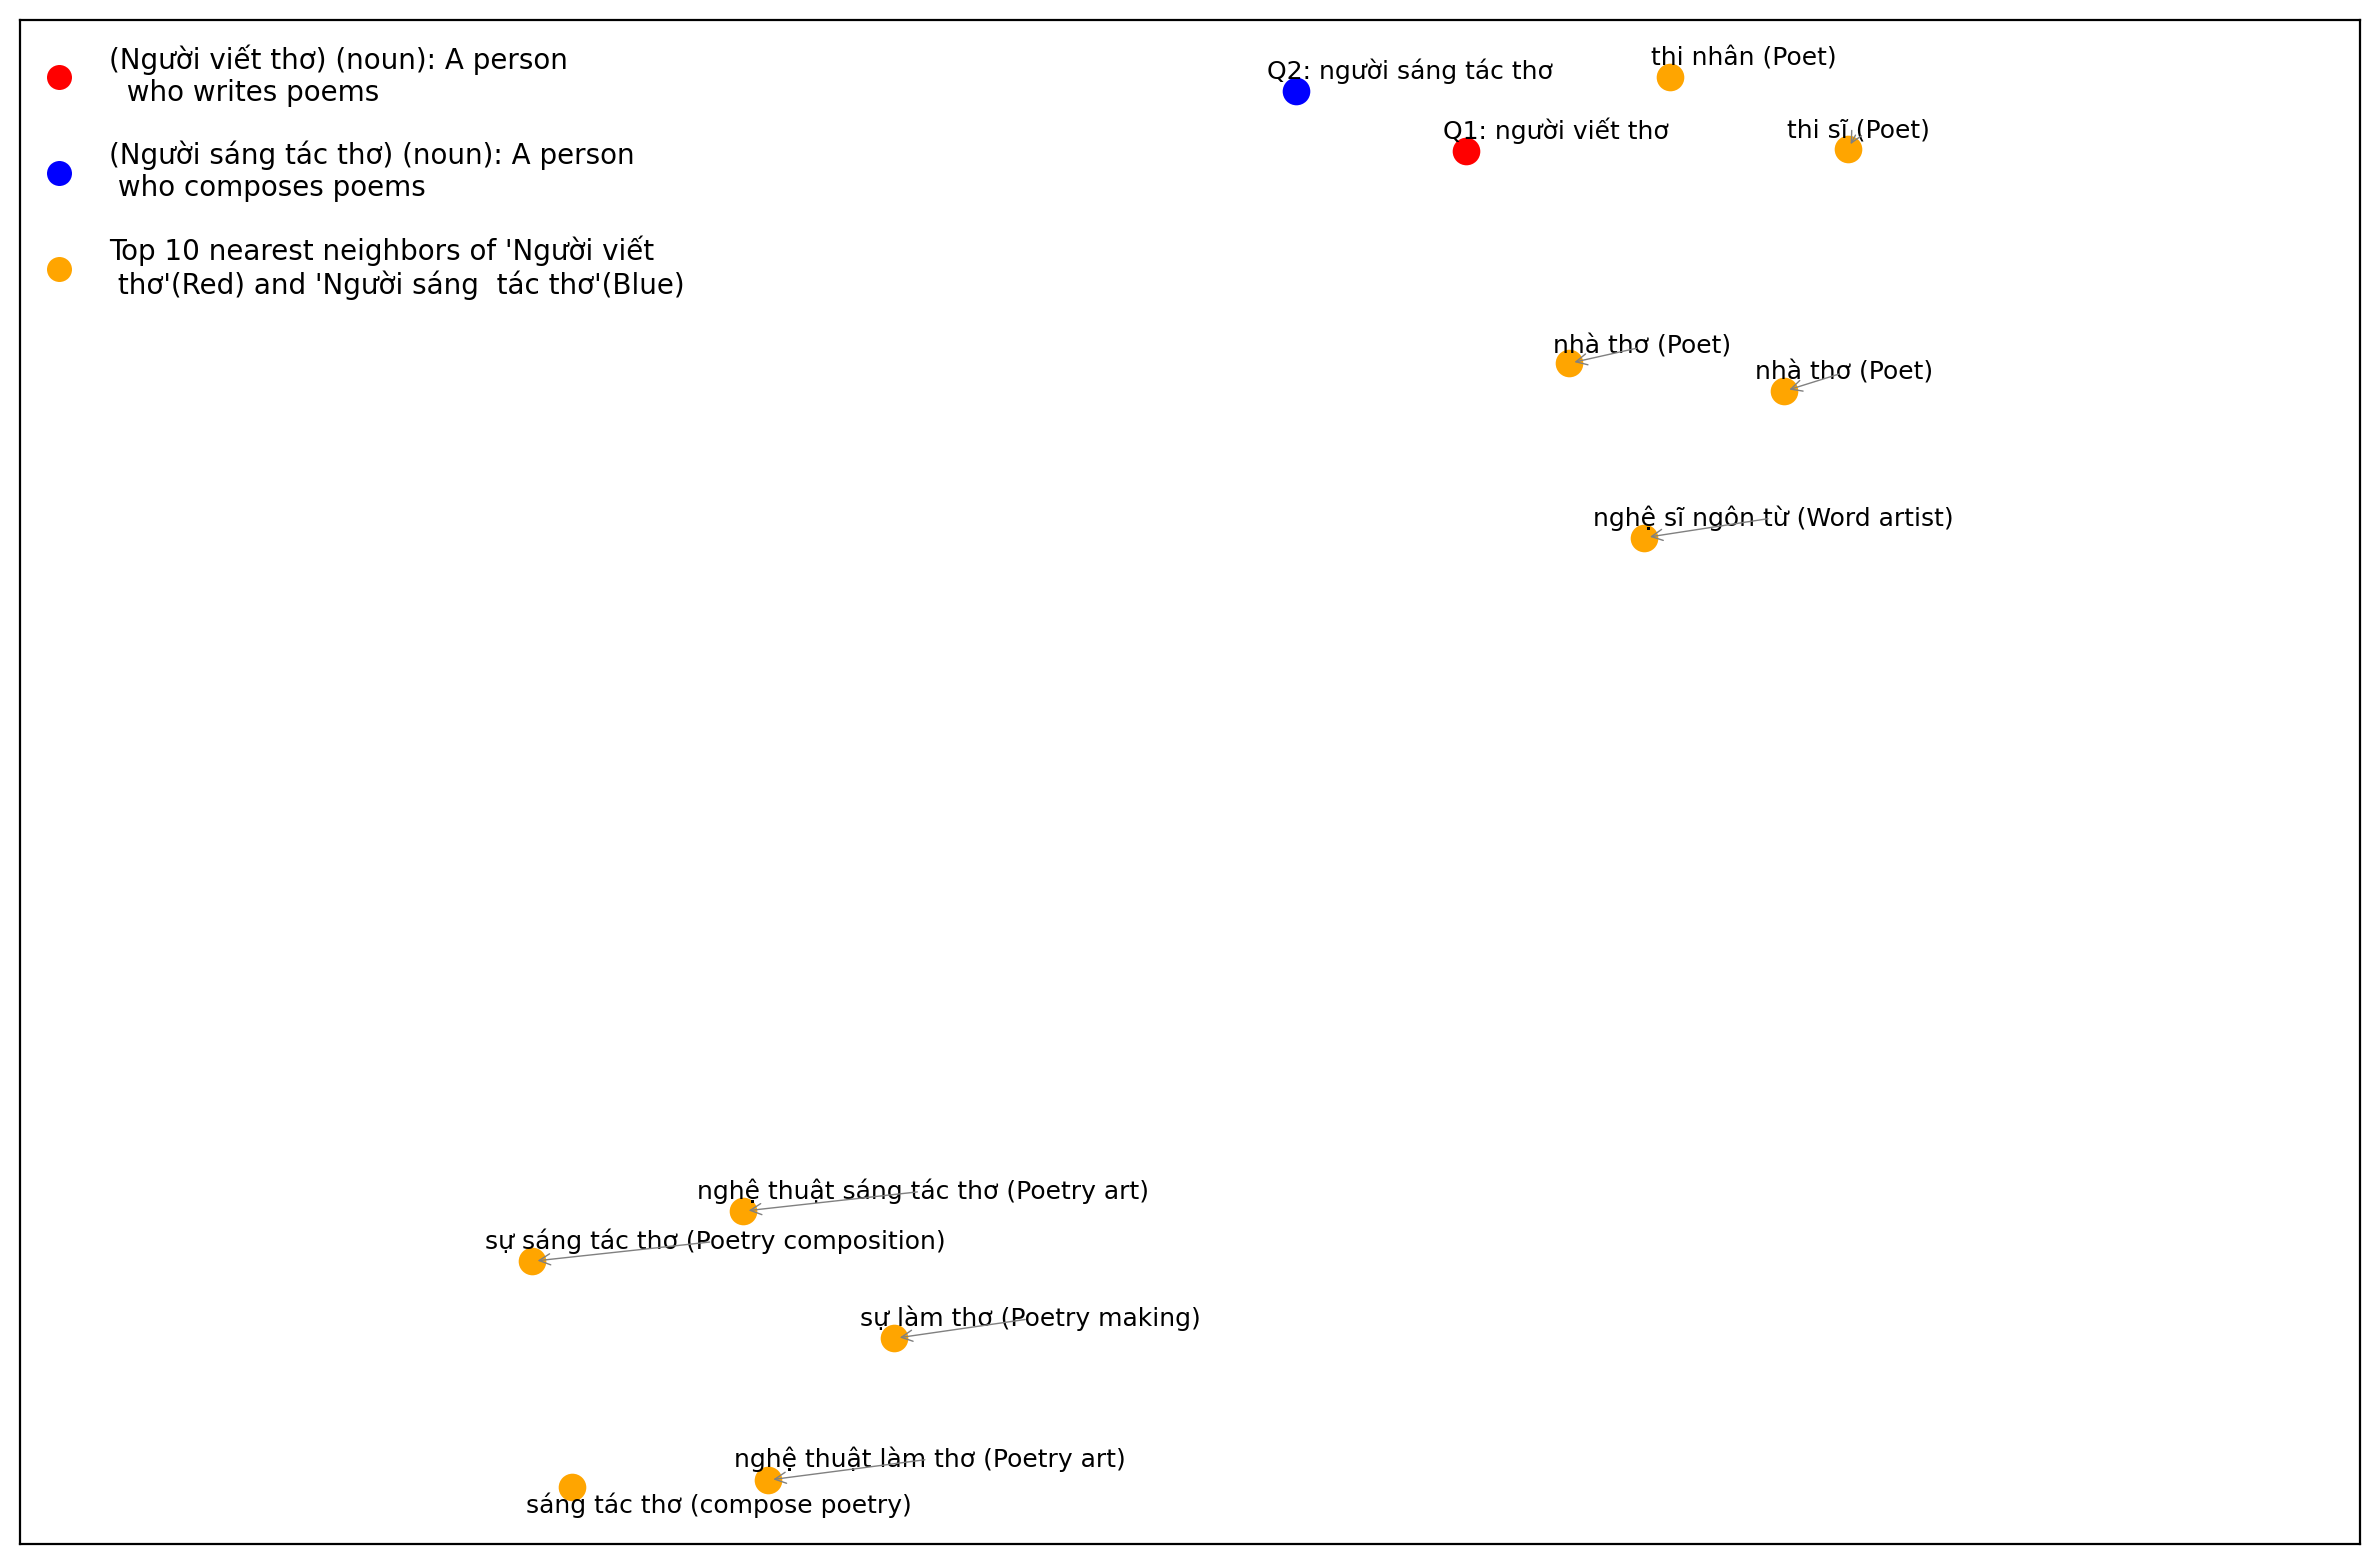

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap       # pip install umap-learn
from adjustText import adjust_text  # pip install adjustText
from matplotlib.lines import Line2D

# --- 1. Chuẩn bị 2 query và targets ---
queries = [
    ("Đây là người viết thơ rất nổi tiếng.", "người viết thơ"),
    ("Anh ấy là người sáng tác thơ.",   "người sáng tác thơ"),
]
colors_query = ["red", "blue"]
colors_nn    = ["orange", "cyan"]

# --- 2. Lấy vector query và top‑K neighbours ---
all_vecs   = []
all_labels = []
all_colors = []

seen_idxs = set()
for qi, (q_text, q_target) in enumerate(queries):
    # lấy vec query
    q_vec = pipeline(q_text, q_target).detach().cpu().numpy().reshape(-1)
    D, I   = index.search(q_vec[np.newaxis, :], k=10)

    # thêm query vào lists
    all_vecs.append(q_vec)
    all_labels.append(f"Q{qi+1}: {q_target}")
    all_colors.append(colors_query[qi])

    # top‑K nhưng bỏ trùng với seen_idxs
    for idx in I[0]:
        if idx in seen_idxs:
            continue
        seen_idxs.add(idx)
        nn_vec = np.array(index.reconstruct(int(idx))).reshape(-1)
        all_vecs.append(nn_vec)
        word = metadata[idx]['word']
        all_labels.append(word)
        all_colors.append(colors_nn[qi])

# --- 3. Giảm chiều bằng UMAP ---
all_vecs = np.vstack(all_vecs)
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
emb_2d   = reducer.fit_transform(all_vecs)
plt.figure(figsize=(12, 8), dpi=200)
translation_map = {
    'người viết thơ': 'Poet',
    'thi nhân': 'Poet',
    'thi sĩ': 'Poet',
    'nhà thơ': 'Poet',
    'sáng tác thơ': 'compose poetry',
    'nghệ thuật sáng tác thơ': 'Poetry art',
    'nghệ thuật làm thơ': 'Poetry art',
    'sự làm thơ': 'Poetry making',
    'sự sáng tác thơ': 'Poetry composition',
    'nghệ sĩ ngôn từ': 'Word artist',
    'người sáng tác thơ': 'Poet',
}

# Tạo list mới với bản dịch trong ngoặc
all_labels = [f"{w} ({translation_map.get(w, 'N/A')})" if translation_map.get(w, 'N/A') != 'N/A' else w for w in all_labels]    
    
text_objs = []
for (x, y), label, c in zip(emb_2d, all_labels, all_colors):
    plt.scatter(x, y, color=c, s=80)
    text_objs.append(plt.text(x, y, label, fontsize=9))

adjust_text(text_objs,
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
            expand_text=(1.2, 1.2),
            force_text=0.5)

# Legend ngoài plot
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"(Người viết thơ) (noun): A person \n  who writes poems ",
           markerfacecolor=colors_query[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"(Người sáng tác thơ) (noun): A person \n who composes poems",
        markerfacecolor=colors_query[1], markersize=10)
] + [
    Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'Người viết \n thơ'(Red) and 'Người sáng  tác thơ'(Blue)",
           markerfacecolor=colors_nn[0], markersize=10)
]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0, 0.90),
           framealpha=1, borderaxespad=0,    frameon=False,  labelspacing=1.2    # xóa khung
)

plt.axis("equal")
plt.gca().set_xticks([])  # xóa tick trên trục x
plt.gca().set_yticks([])  
# plt.axis("off")
plt.tight_layout()
plt.show()

e:\Course\UIT\UIT-Final Thesis\SynoViSense\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


['Q1: chạy', 'đi đến chỗ', 'việc chạy', 'chạy', 'chuyển động', 'chạy', 'di chuyển', 'thành ra', 'đi đến', 'đi', 'di chuyển', 'Q2: chạy', 'chạy', 'hoạt động', 'vận hành', 'vận hành', 'chạy', 'chạy', 'vận hành', 'điều khiển', 'điều khiển', 'hoạt động']


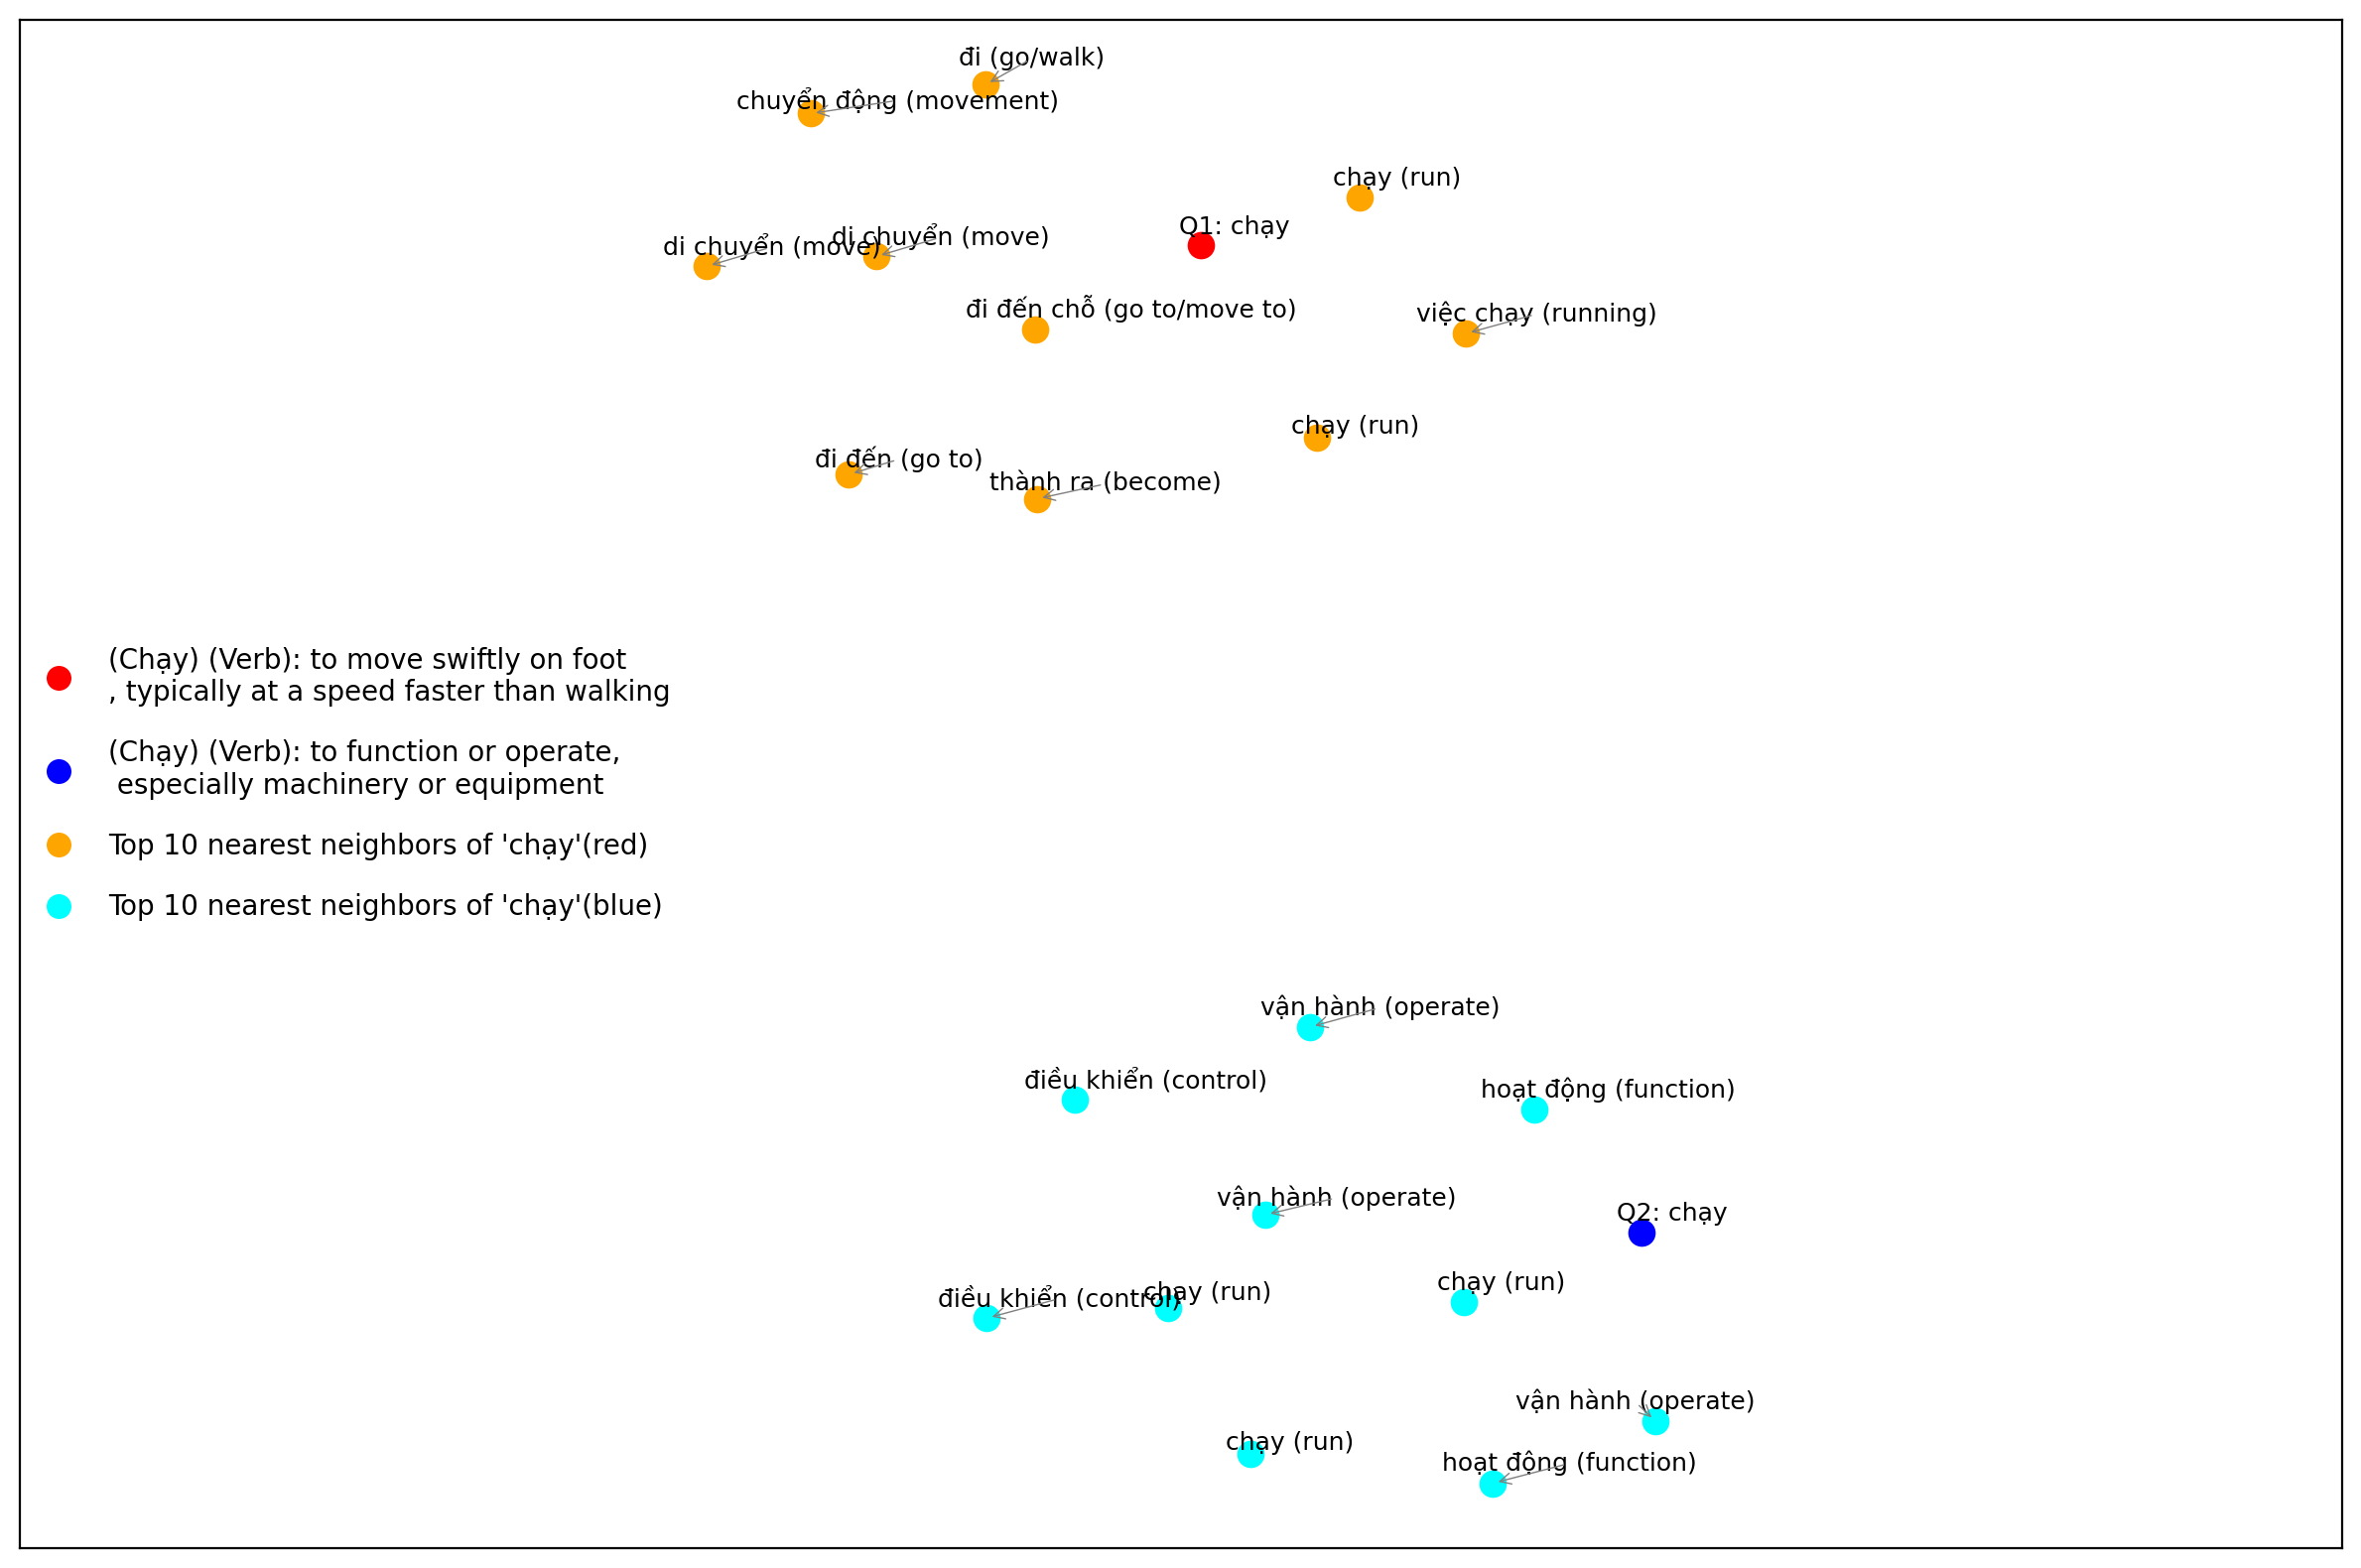

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap       # pip install umap-learn
from adjustText import adjust_text  # pip install adjustText
from matplotlib.lines import Line2D

# --- 1. Chuẩn bị 2 query và targets ---
queries = [
    ("Anh ấy chạy rất nhanh.", "chạy"),
    ("Cỗ máy mới này chạy rất ổn định.",   "chạy"),
]
colors_query = ["red", "blue"]
colors_nn    = ["orange", "cyan"]

# --- 2. Lấy vector query và top‑K neighbours ---
all_vecs   = []
all_labels = []
all_colors = []

seen_idxs = set()
for qi, (q_text, q_target) in enumerate(queries):
    # lấy vec query
    q_vec = pipeline(q_text, q_target).detach().cpu().numpy().reshape(-1)
    D, I   = index.search(q_vec[np.newaxis, :], k=10)

    # thêm query vào lists
    all_vecs.append(q_vec)
    all_labels.append(f"Q{qi+1}: {q_target}")
    all_colors.append(colors_query[qi])

    # top‑K nhưng bỏ trùng với seen_idxs
    for idx in I[0]:
        if idx in seen_idxs:
            continue
        seen_idxs.add(idx)
        nn_vec = np.array(index.reconstruct(int(idx))).reshape(-1)
        all_vecs.append(nn_vec)
        word = metadata[idx]['word']
        all_labels.append(word)
        all_colors.append(colors_nn[qi])

# --- 3. Giảm chiều bằng UMAP ---
all_vecs = np.vstack(all_vecs)
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42,min_dist=0.5
                    )
emb_2d   = reducer.fit_transform(all_vecs)
print(all_labels)
translation_map = {
    # 'Q1: chạy': 'run (person)',
    'đi đến chỗ': 'go to/move to',
    'việc chạy': 'running',
    'chạy': 'run',
    'chuyển động': 'movement',
    'di chuyển': 'move',
    'thành ra': 'become',
    'đi đến': 'go to',
    'đi': 'go/walk',
    # 'Q2: chạy': 'run / operate (machine)',
    'hoạt động': 'function',
    'vận hành': 'operate',
    'điều khiển': 'control'
}
all_labels = [f"{w} ({translation_map.get(w, 'N/A')})" if translation_map.get(w, 'N/A') != 'N/A' else w for w in all_labels]    

# --- 4. Vẽ scatter + dàn nhãn ---
plt.figure(figsize=(12, 8), dpi=200)
text_objs = []
for (x, y), label, c in zip(emb_2d, all_labels, all_colors):
    plt.scatter(x, y, color=c, s=80)
    text_objs.append(plt.text(x, y, label, fontsize=9))

adjust_text(text_objs,
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
            expand_text=(1.2, 1.2),
            force_text=0.5)

# --- 5. Tạo legend thủ công ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"(Chạy) (Verb): to move swiftly on foot \n, typically at a speed faster than walking ",
           markerfacecolor=colors_query[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', label=f"(Chạy) (Verb): to function or operate, \n especially machinery or equipment",
        markerfacecolor=colors_query[1], markersize=10)
] + [
    Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'chạy'(red)",
           markerfacecolor=colors_nn[0], markersize=10),
        Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'chạy'(blue) ",
           markerfacecolor=colors_nn[1], markersize=10)
]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0, 0.5),
           framealpha=1, borderaxespad=0,    frameon=False,  labelspacing=1.2    # xóa khung
)

plt.axis("equal")
plt.gca().set_xticks([])  # xóa tick trên trục x
plt.gca().set_yticks([]) 
plt.tight_layout()
plt.show()


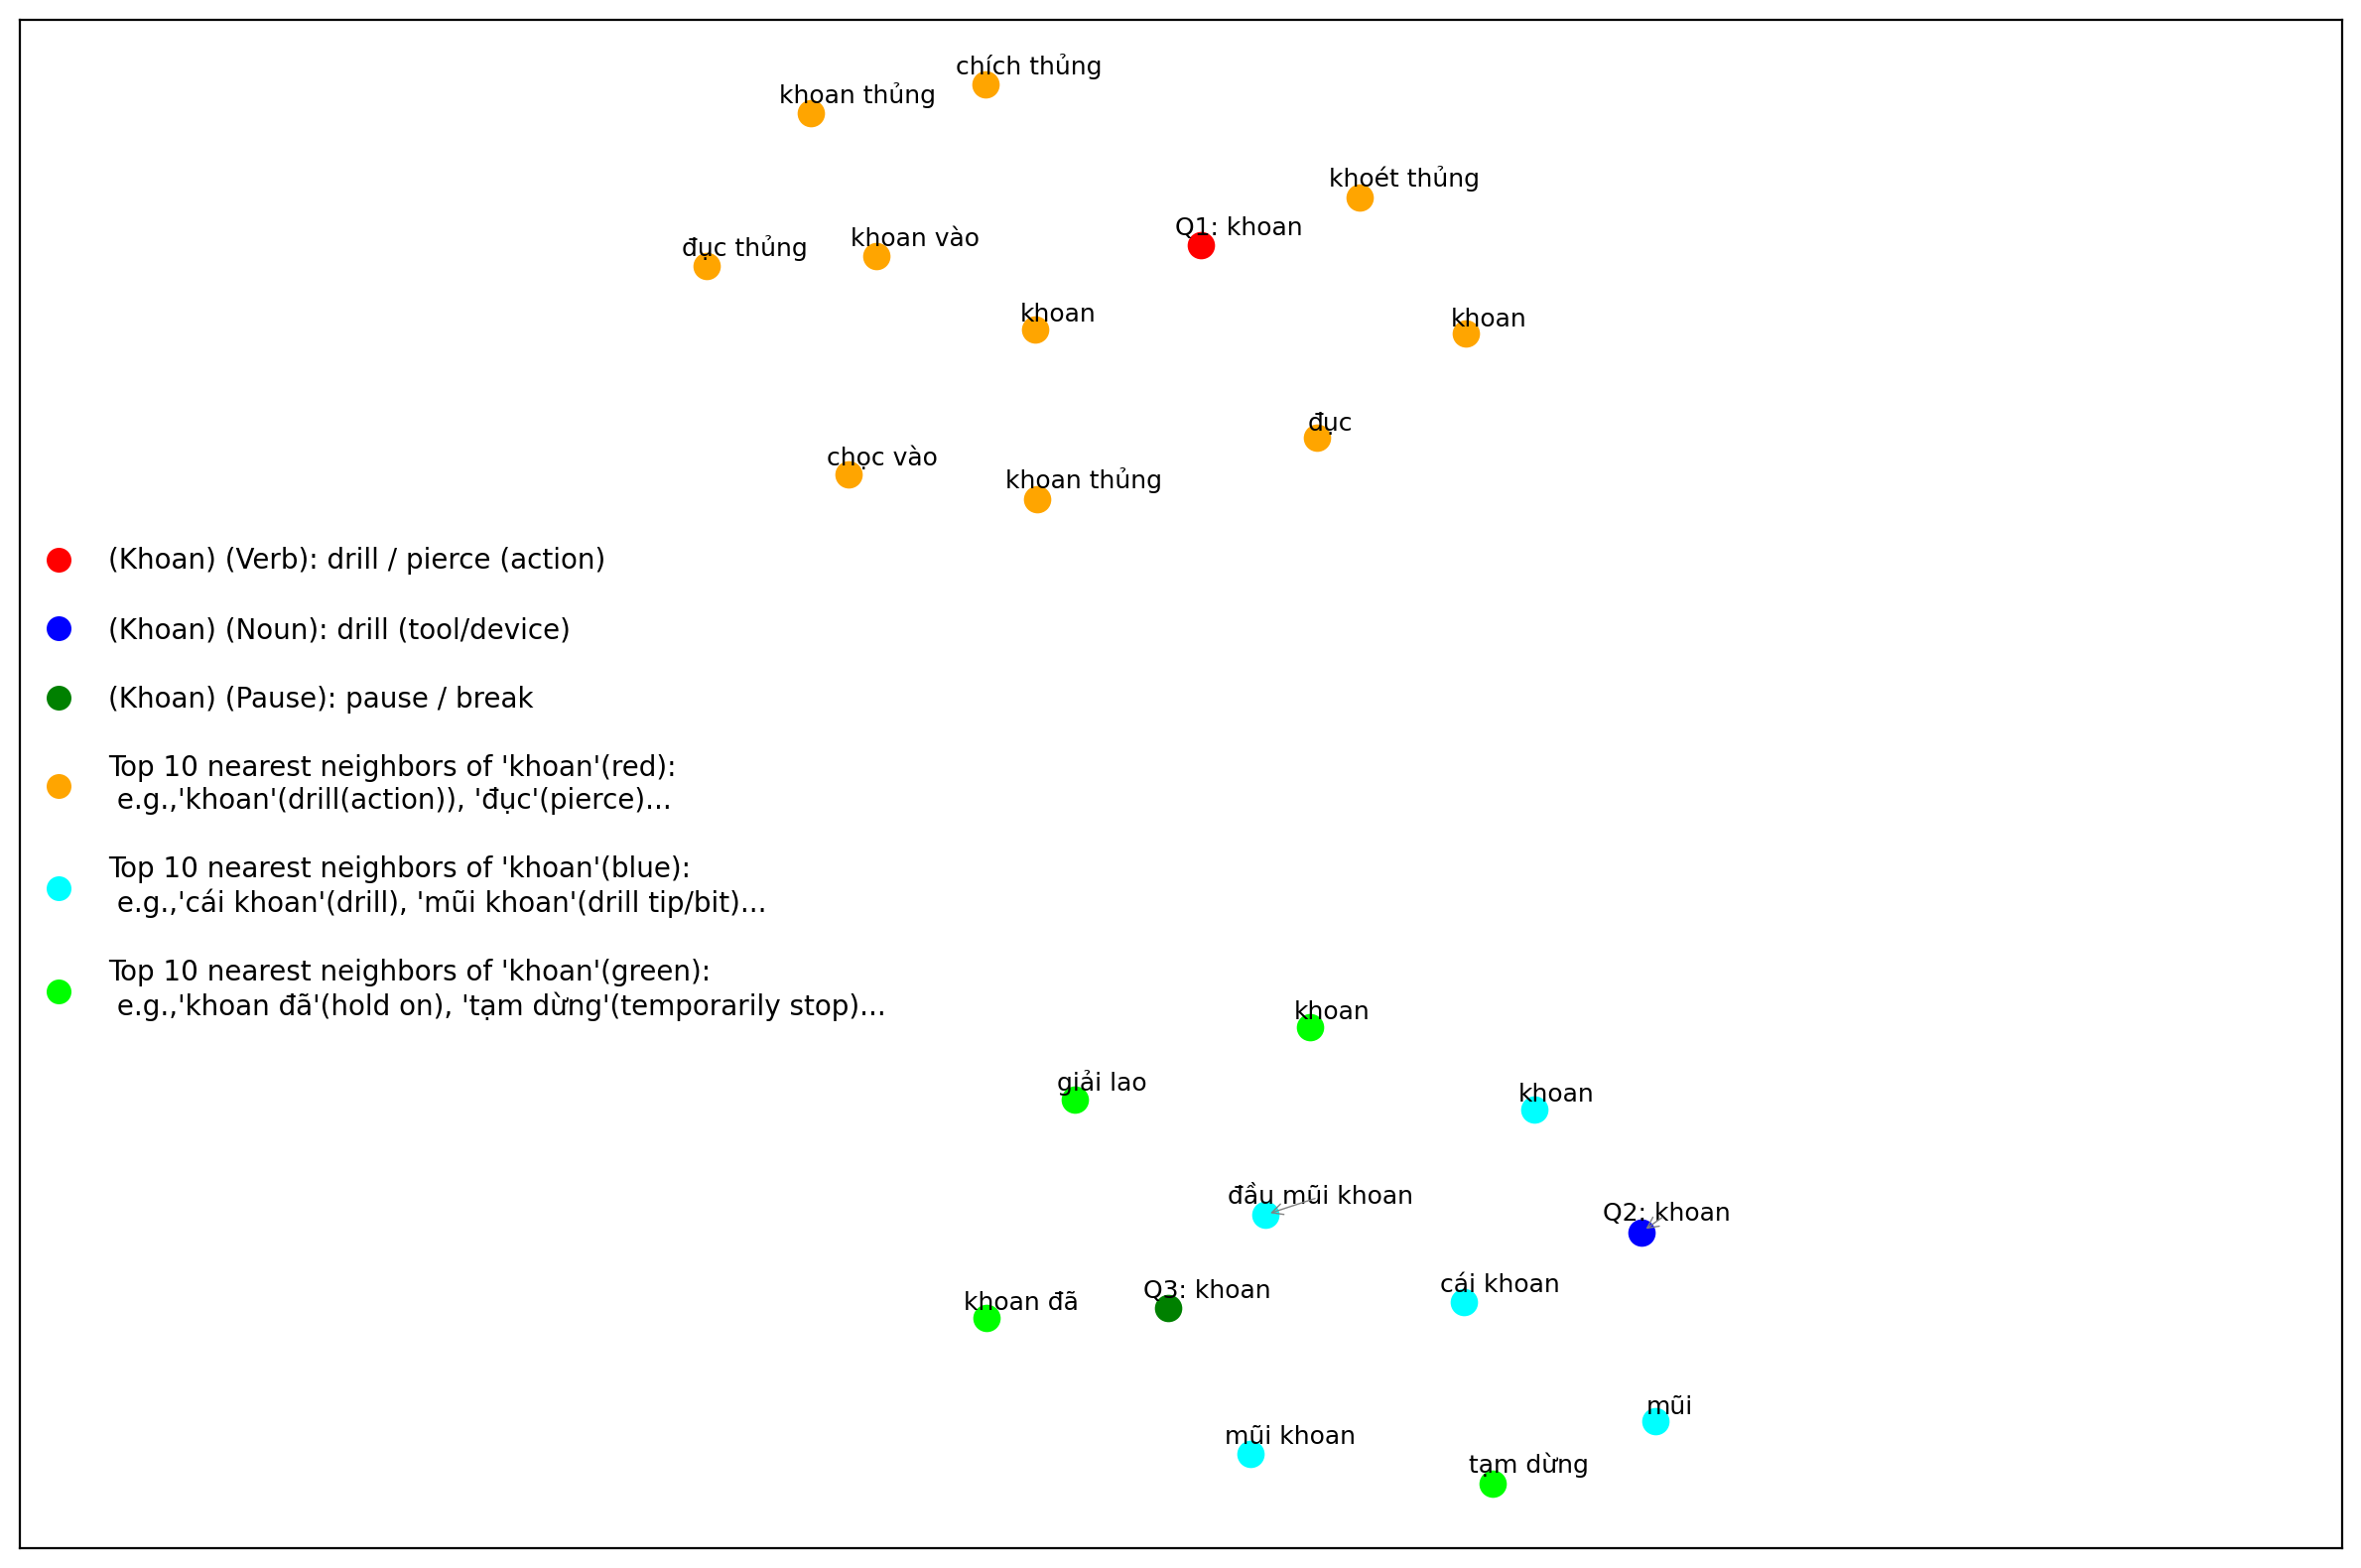

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import umap.umap_ as umap       # pip install umap-learn
from adjustText import adjust_text  # pip install adjustText
from matplotlib.lines import Line2D

# --- 1. Chuẩn bị 2 query và targets ---
queries = [
    ("khoan tường.",  "khoan"),
    ("Cái khoan.", "khoan"),
    ("khoan, đừng làm thế.",   "khoan"),
]
colors_query = ["red", "blue","green"]
colors_nn    = ["orange", "cyan","lime"]

# --- 2. Lấy vector query và top‑K neighbours ---
all_vecs   = []
all_labels = []
all_colors = []

seen_idxs = set()
for qi, (q_text, q_target) in enumerate(queries):
    # lấy vec query
    q_vec = pipeline(q_text, q_target).detach().cpu().numpy().reshape(-1)
    D, I   = index.search(q_vec[np.newaxis, :], k=10)

    # thêm query vào lists
    all_vecs.append(q_vec)
    all_labels.append(f"Q{qi+1}: {q_target}")
    all_colors.append(colors_query[qi])

    # top‑K nhưng bỏ trùng với seen_idxs
    for idx in I[0]:
        if idx in seen_idxs:
            continue
        seen_idxs.add(idx)
        nn_vec = np.array(index.reconstruct(int(idx))).reshape(-1)
        all_vecs.append(nn_vec)
        word = metadata[idx]['word']
        all_labels.append(word)
        all_colors.append(colors_nn[qi])

# --- 3. Giảm chiều bằng UMAP ---
all_vecs = np.vstack(all_vecs)
reducer = umap.UMAP(n_components=2,n_neighbors=10, metric='cosine', random_state=42,min_dist=4, spread=4
                    )

# --- 4. Vẽ scatter + dàn nhãn ---
plt.figure(figsize=(12, 8), dpi=200)
text_objs = []
for (x, y), label, c in zip(emb_2d, all_labels, all_colors):
    plt.scatter(x, y, color=c, s=80)
    text_objs.append(plt.text(x, y, label, fontsize=9))

adjust_text(text_objs,
            arrowprops=dict(arrowstyle="->", color='gray', lw=0.5),
            expand_text=(1.2, 1.2),
            force_text=0.5)

# --- 5. Tạo legend thủ công ---
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           label="(Khoan) (Verb): drill / pierce (action)", 
           markerfacecolor=colors_query[0], markersize=10),
    Line2D([0], [0], marker='o', color='w', 
           label="(Khoan) (Noun): drill (tool/device)", 
           markerfacecolor=colors_query[1], markersize=10),
    Line2D([0], [0], marker='o', color='w', 
           label="(Khoan) (Pause): pause / break", 
           markerfacecolor=colors_query[2], markersize=10)
] + [
    Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'khoan'(red):\n e.g.,'khoan'(drill(action)), 'đục'(pierce)...",
           markerfacecolor=colors_nn[0], markersize=10),
        Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'khoan'(blue):\n e.g.,'cái khoan'(drill), 'mũi khoan'(drill tip/bit)...",
           markerfacecolor=colors_nn[1], markersize=10),
                Line2D([0], [0], marker='o', color='w', label=f"Top 10 nearest neighbors of 'khoan'(green):\n e.g.,'khoan đã'(hold on), 'tạm dừng'(temporarily stop)... ",
           markerfacecolor=colors_nn[2], markersize=10)
]

plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0, 0.5),
           framealpha=1, borderaxespad=0,    frameon=False,  labelspacing=1.5    # xóa khung
)

plt.axis("equal")
plt.gca().set_xticks([])  # xóa tick trên trục x
plt.gca().set_yticks([]) 
plt.tight_layout()
plt.show()
